# Energy production in Spain
## Summary
We want to optimize the generation of electricity for REE ('Red Eléctrica Española', Spanish electric grid operator). In order to do that, we must adjust the energy produced by the different facilities which are grouped by technology and region, taking into account:
- The national energy demand must be met (this is critical, obviously!).
- To achieve the objectives agreed upon to fight climate change, the emissions of CO2 are capped.
- Each region has a certain maximum capacity to produce energy in each of the different ways. Each region has a certain maximum capacity to produce energy in each of the different ways


## Problem Statement

The problem can be mathematically formulated as a linear programming problem using the following model: 

### Sets

 $P$ = set of combinations 'Source - Region'
  
### Parameters

 $c_i$ = energy production cost $[€/MWh]$ of combination $i$ , ($\forall i \in P$)
 
 $D$ = national energy demand $[MWh]$
 
 $CO_2max$ = CO2 emissions cap $[tCO_2]$
 
 $Cmax_i$ = maximum capacity $[MWh]$ of facility $i$ , ($\forall i \in P$)
 
 $a_i$ = amount of CO2 emitted $[tCO_2/MWh]$ per combination $i$ , ($\forall i \in P$)
 
### Decision variables

 $x_i$ = energy produced by combination $i$ in $[MWh]$

### Objective function

Minimize the total cost of production:

 $$\min z=\sum_{i \in P} c_i x_i$$

### Constraints

Meeting national energy demand:

$$\sum_{i \in P} x_i \geq D$$
 
Emissions cap:

$$\sum_{i \in P} a_i x_i \leq CO_2max$$
 
Capacity limit for each facility:

$$x_i \leq Cmax_i, \quad \forall i \in P$$
 
Production lower bound,

$$x_i \geq 0, \quad \forall i \in P$$


## Data
For production data, we recur to different sources:
- For maximum nominal capacities ($Cmax_i$), we use REE publications, [*2018 Spanish Electric System Report*](https://www.ree.es/es/datos/publicaciones/informe-anual-sistema/informe-del-sistema-electrico-espanol-2018). For the sake of simplicity, we assume that the maximum nominal capacity of each one is its installed power (in $MW$) multiplied by a unit hour ($h$). 

- For the production cost by source ($c_i$), we use data from [*Lazard's Levelized Cost of Energy Analysis (v 13.0)*](https://www.lazard.com/media/451086/lazards-levelized-cost-of-energy-version-130-vf.pdf) and the [*Annual Energy Outlook 2019*](https://www.eia.gov/outlooks/aeo/pdf/electricity_generation.pdf) by the US Energy Information Adminisistration (EIA). Even though the values of LCOE are expressed in US/MWh, we use them as if they were €.

- For the CO2 emissions factor by source ($a_i$), we use the following report from the Covenant of Mayors [SEAP report](https://www.eumayors.eu/IMG/pdf/technical_annex_en.pdf).

- The national energy demand ($D$) to meet is arbitrarily defined by us (taking into account the rest of parameter's values so the problem is consistent).

- The CO2 emissions cap ($CO_{2}max$) is also arbitrarily defined by us (taking into account the rest of parameter's values so the problem is consistent).

Another observation is that for the sake of simplicity only the peninsular component of the Spanish electric network will be studied, excluding the Canary Islands, Balearic Islands, Ceuta and Melilla due to its particular characteristics.

Also, hidroeolian, biogas, biomass, geothermal, marine hydroelectric nor waste generation facilities are taken into account. The sum of the installed power of all of them amounts to just 1% of the total, so it is considered negligible and would complicate the analysis without providing added value.


In [1]:
##### Import required libraries
import numpy as np
import pandas as pd

from pyomo.environ import *
from pyomo.opt import SolverFactory
opt = SolverFactory("glpk")

from time import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
####################### DATA GENERATION ###########################
np.random.seed(12345) #For reproducibility of results

df = pd.read_csv("production.csv", sep=";") #Data file with values of capacities for Source-Region

n = len(df)

# Indexes for sources
idx_H   = df.index[df["P"].str.contains('Hydro')]
idx_HP  = df.index[df["P"].str.contains('Pumped')]
idx_N   = df.index[df["P"].str.contains('Nuclear')]
idx_C   = df.index[df["P"].str.contains('Coal')]
idx_F   = df.index[df["P"].str.contains('Fuel')]
idx_CC  = df.index[df["P"].str.contains('Comb')]
idx_W   = df.index[df["P"].str.contains('Wind')]
idx_PH  = df.index[df["P"].str.contains('Photo')]
idx_TS  = df.index[df["P"].str.contains('Thermal')]
idx_COG = df.index[df["P"].str.contains('Cog')]

# Indexes for renewable and non-renewable sources
idx_R = idx_H.append([idx_HP, idx_W, idx_PH, idx_TS])
idx_R = np.sort(idx_R)
idx_NR = idx_N.append([idx_C, idx_F, idx_CC, idx_COG])
idx_NR = np.sort(idx_NR)

# Production cost for each plant
c = np.zeros(n)
c[idx_H]   = np.random.normal(loc=39.1, scale=5, size=len(idx_H)) #Production cost for Hydroelectric
c[idx_HP]  = np.random.normal(loc=32, scale=5, size=len(idx_HP)) #Production cost for Pumped hydroelectric
c[idx_N]   = np.random.normal(loc=100, scale=37, size=len(idx_N)) #Production cost for Nuclear
c[idx_C]   = np.random.normal(loc=80, scale=43, size=len(idx_C)) #Production cost for Coal
c[idx_F]   = np.random.normal(loc=174.5, scale=24.5, size=len(idx_F)) #Production cost for Fuel/gas
c[idx_CC]  = np.random.normal(loc=56, scale=12, size=len(idx_CC)) #Production cost for Combined cycle
c[idx_W]   = np.random.normal(loc=65, scale=13, size=len(idx_W)) #Production cost for Wind
c[idx_PH]  = np.random.normal(loc=70, scale=10, size=len(idx_PH)) #Production cost for Photovoltaic solar
c[idx_TS]  = np.random.normal(loc=141, scale=15, size=len(idx_TS)) #Production cost for Thermal solar
c[idx_COG] = np.random.normal(loc=180, scale=35, size=len(idx_COG)) #Production cost for Cogeneration

D = 6e4 #Electricity demand (MWh)
E = D*0.025 #CO2 emissions cap (tCO2)

# Raise exception if input 'D' > sum(Cmax)
if D > sum(df["Cmax"]):
    raise Exception("The demand input ({:.2f} MWh) is bigger thant the total system capacity ({:.2f} MWh)".format(D, sum(df["Cmax"])))
if D <= 0:
    raise Exception("The demand input ({:.2f} MWh) must be positive".format(D))
if E <= 0:
    raise Exception("The emissions cap input ({:.2f} tCO2) must be positive".format(E))

# Maximum nominal capacity for each combination (MWh)
Cmax = np.zeros(n)
Cmax = df["Cmax"]

# CO2 emissions factor (tCO2/MWh)
a = np.zeros(n)
a[idx_C]   = np.random.normal(loc=0.351, scale=0.012, size=len(idx_C)) #CO2 emissions factor for Coal
a[idx_F]   = np.random.normal(loc=0.273, scale=0.006, size=len(idx_F)) #CO2 emissions factor for Fuel/gas
a[idx_CC]  = np.random.normal(loc=0.202, scale=0.003, size=len(idx_CC)) #CO2 emissions factor for Combined cycle
a[idx_COG] = np.random.normal(loc=0.330, scale=0.010, size=len(idx_COG)) #CO2 emissions factor for Cogeneration

# Adding value parameters to dataframe
df.insert(1, "c", c)
df.insert(3, "a", a)

# Exporting to data file (.csv)
df.to_csv(path_or_buf="production_data.csv", index=False)

Here we can see the resulting data matrix for our problem:

In [3]:
# We define this dataframe just for data visualization
df_show = df.rename(columns={"P":"P (Source-Region)", 
                   "c":"c (€/MWh)",
                   "Cmax":"Cmax (MWh)",
                   "a":"a (tCO2/MWh)"}
              )
print(df_show.set_index("P (Source-Region)").to_string())

                                              c (€/MWh)   Cmax (MWh)  a (tCO2/MWh)
P (Source-Region)                                                                 
Hydroelectric - Andalucia                     38.076462   589.574000      0.000000
Pumped hydroelectric - Andalucia              36.432147   582.880000      0.000000
Nuclear - Andalucia                           73.598873     0.000000      0.000000
Coal - Andalucia                              92.313039  1989.400000      0.341914
Fuel/gas - Andalucia                         195.633212     0.000000      0.281641
Combined cycle - Andalucia                    49.962951  5951.720000      0.200298
Wind - Andalucia                              67.446739  3327.180500      0.000000
Photovoltaic solar - Andalucia                69.637362   881.972959      0.000000
Thermal solar - Andalucia                    107.208041  1000.023000      0.000000
Cogeneration - Andalucia                     199.430404   848.959500      0.339110
Hydr

## Model implementation
Now, we proceed to implement the model using the <code>pyomo</code> package as an <code>AbstractModel</code> using the *GNU Linear Programming Kit (GLPJK)* as solver.

We are going to define a function <code>energy_opt</code> in order to call it any time we need to display the results. We are going to pass as arguments to the functions just the constant values of demand and emissions (<code>D</code> and <code>E</code>). The rest of problem parameters are loaded into the model's <code>instance</code> used to solve our particular case using Pyomo's <code>DataPortal</code> method.

In [4]:
def energy_opt(D,E):

    model = AbstractModel(name="Spanish energy production")
    
    data = DataPortal()
    
    ## SET
    model.P = Set()
    
    ## PARAMETERS
    # Costs of electricity production
    model.c    = Param(model.P, within=NonNegativeReals)
    # Maximum capacities
    model.Cmax = Param(model.P, within=NonNegativeReals)
    # CO2 emissions factor
    model.a    = Param(model.P, within=NonNegativeReals)
    
    data.load(filename="production_data.csv", using="csv", param=(model.c,model.Cmax,model.a), index=model.P)
   
    ## DECISION VARIABLES
    # Electricity produced in each facility
    model.x = Var(model.P, within=NonNegativeReals)

    ## OBJECTIVE FUNCTION
    # Minimize the total cost of electricity production
    def cost_rule(model):
        return sum(model.c[i]*model.x[i] for i in model.P)
    model.cost_obj = Objective(rule=cost_rule)

    ## CONSTRAINTS
    # Meeting demand
    def demand_rule(model):
        return sum(model.x[i] for i in model.P) >= D
    model.demand_constraint = Constraint(rule=demand_rule)

    # CO2 emissions cap
    def emissions_rule(model):
        return sum(model.a[i]*model.x[i] for i in model.P) <= E
    model.emissions_constraint = Constraint(rule=emissions_rule)

    # Capacity limits
    def capacity_rule(model, i):
        return model.x[i] <= model.Cmax[i]
    model.capacity_constraint = Constraint(model.P, rule=capacity_rule)
    
    instance = model.create_instance(data)
    instance.dual = Suffix(direction=Suffix.IMPORT)
    opt.solve(instance)

    return instance, instance.dual

## Solution
Now, we proceed to compute the model solution using the defined function <code>energy_opt()</code>. We assign two variables for storing the results as <code>primal</code> is the solution for this first section, but we are going to need also <code>dual</code> as it constitutes the solution for the dual problem which would be of use for the next section, as we will see later. 

In [5]:
[primal, dual] = energy_opt(D,E)
primal.display()

Model Spanish energy production

  Variables:
    x : Size=150, Index=P
        Key                                         : Lower : Value            : Upper : Fixed : Stale : Domain
                                   Coal - Andalucia :     0 :              0.0 :  None : False : False : NonNegativeReals
                                      Coal - Aragon :     0 :              0.0 :  None : False : False : NonNegativeReals
                                    Coal - Asturias :     0 :              0.0 :  None : False : False : NonNegativeReals
                                   Coal - Cantabria :     0 :              0.0 :  None : False : False : NonNegativeReals
                             Coal - Castilla y Leon :     0 :              0.0 :  None : False : False : NonNegativeReals
                          Coal - Castilla-La Mancha :     0 :              0.0 :  None : False : False : NonNegativeReals
                                   Coal - Catalunya :     0 :              0.0 :  No

Some remarks we can extract from the solution displayed above are:
- The optimal value for our objective function is equal to **3,430,343.85 €**.
- We are mostly producing electricity via renewable energies, specially *Wind*, *Hydroelectric* and *Photovoltaic* and then the rest corresponds to non-renewable such as *Nuclear* and *Combined cycle*. The exaggerated preponderance of renewables is due to the fact that they best meet the objective of minimizing cost (as all three mentioned have a very low average cost) and meeting emissions (as they do not produce CO2). In reference to the cost, this is not realistic, since in spite of the values used for LCOE by source being real, they do not take into account the extra costs of connection/disconnection to the grid, start/stop of plants or availability depending on the climatic conditions, all these key variables in the real situation.
- The demand is *exactly* met with a production of **60,000 MWh**. This makes sense as it is a linear problem, where producing *more* electricity implies *more* expenses, as we do not consider other factors as energy or emissions market.
- The emissions cap is reached with **1,500 tCO2**.
- In the majority of cases when we *are* actually producing from a region with a concrete source (that is, when its corresponding decision variable is not null) we are using its *whole* capacity (that is, we are consuming the whole resource for that constraint). This makes sense according to our problem formulation, as if one source is cheap and clean, it is logical to try to use it up to the maximum, as the capacity constraint is not affected by anything else than the decision variable. 
***

## Sensitivity analysis

In order to compute the sensitivity of our constraints, we need to compute the following parameter:

$$ \lambda_i =  \frac{\Delta z^*} {\Delta b_i} $$

In order to obtain the $\lambda$ parameter in Pyomo, we use the duality theorem, as we know that these are equivalent to the solution set of dual decision variables.

In [6]:
dual.display()

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key                                                              : Value
                               capacity_constraint[Coal - Andalucia] :                0.0
                                  capacity_constraint[Coal - Aragon] :                0.0
                                capacity_constraint[Coal - Asturias] :                0.0
                               capacity_constraint[Coal - Cantabria] :                0.0
                         capacity_constraint[Coal - Castilla y Leon] :                0.0
                      capacity_constraint[Coal - Castilla-La Mancha] :                0.0
                               capacity_constraint[Coal - Catalunya] :                0.0
                    capacity_constraint[Coal - Comunidad Valenciana] :                0.0
                             capacity_constraint[Coal - Extremadura] :                0.0
                                 capacity_constraint[Coal -

When interpreting the sensitivity analysis of our constraints, we can observe:
- For the different capacity constraints we only observe negative or null values. These values make sense, since those zero values correspond to the cases where we are not using all the available capacity ($x^*_i < Cmax_i$), that is, we still have margin in the consumption of the resource, so it does not make sense to increase the value of it, since it would not affect the result of the objective function. In those cases where we have negative values it means that we are producing at the maximum of the capacity ($x^*_i = Cmax_i$), so a unit increase in the corresponding resource would mean that we could increase the production within that particular source, which would be consumed instead of other options due to its cheap cost and therefore it would help to reduce the total cost.
- As for the demand constraint, we have a positive value, which tells us that if we increased the required demand by one unit, the total cost would increase by **104.43 €**. This is logical, as we need to spend more money anyway to meet the increased demand.
- Finally, with regard to the constraint on emissions, we have a negative value, which tells us that if we increase the permitted CO2 emissions by one unit, we would save **271.95 €**. This is explained by the fact that it would be allowed to produce "a little more" with the cheapest possible source, regardless of whether this source is more polluting.
***

## Imposing logical constraints

Now, we impose the condition that *at least* K out of the 15 Spanish regions must produce <b>clean energy</b> (that means that the whole electricity production from that region should be generated from renewable sources). Or, what is equivalent, it must not use non-renewable sources.

We consider renewable sources the following:
- Hydroelectric
- Pumped hydroelectric
- Wind
- Photovoltaic solar
- Thermal solar

Thus, the non-renewable sources are:
- Coal
- Fuel/gas
- Combined cycle
- Cogeneration
- Nuclear

### Mathematical formulation

The additional condition translates into the following constraints, where $R$ is the set of Spanish regions and $NR$ is the set of non-renewable sources:

$$ \sum_{i \in NR} x_i = 0, \quad \forall j \in R $$

This transformed into the form of k-folds alternative constraints, with $M_j$ being a big enough value

$$ \sum_{i \in NR} x_i \leq M_j(1-y_j), \quad \forall j \in R $$

$$ K\leq \sum_{j \in R} y_j \leq 15 $$

$$
y_j =
\left\{\begin{array}{ll} 
1, & \text{if constraint $j$ is fulfilled,} \\
0, & \text{if constraint $j$ is not fulfilled}
\end{array} \right. \forall j \in R
$$

In [7]:
################ DATA  ########################
# Define number of constraints to fulfill out of the 15 alternatives
K = 13

# Raise exception if invalid 'K' is input
if (K <= 0) | (K > 15):
    raise Exception("The K value must be in the interval (0,15]")

# Define index for Non-renewable variables
idx_NR = (idx_NR).reshape(15,5)
idx = pd.DataFrame()
for j in range(0,15):
    idx[j] = list(df["P"].loc[idx_NR[j,]])
idx = idx.T
idx.index = ["Andalucia","Aragon","Asturias","Comunidad Valenciana","Cantabria",
             "Castilla-La Mancha","Castilla y Leon","Catalunya","Extremadura",
             "Galicia","La Rioja","Madrid","Murcia","Navarra","Pais Vasco"]

# Define matrix of big-M values (large enough to fulfill constraint when required)
M = np.zeros(15)
for i in range(0,15):
    for j in idx_NR[i,:]:
        M[i] = sum(df["Cmax"][j] for j in idx_NR[i,:]) #indexes for Non-renewable sources splitted by regions
M= pd.DataFrame(M, columns=["M"], index=["Andalucia","Aragon","Asturias","Comunidad Valenciana","Cantabria",
                                       "Castilla-La Mancha","Castilla y Leon","Catalunya","Extremadura",
                                       "Galicia","La Rioja","Madrid","Murcia","Navarra","Pais Vasco"])
M.index.name = "R"

# Exporting to data file (.csv)
M.to_csv(path_or_buf="region_data.csv")

> *We assure the value of the parameter $M_j$ is big enough computing it as the summation of the maximum capacity available from non-renewable sources available in each region:* 
$$ M_j = \sum_{i \in NR} Cmax_i , \quad \forall j \in R $$

In [8]:
def energy_opt_Bin(D,E,K,idx):

    model = AbstractModel(name="Spanish energy production")
    
    data = DataPortal()
    
    ## SET
    model.P = Set()
    model.R = Set()
   
    ## PARAMETERS
    # Costs of electricity production
    model.c    = Param(model.P, within=NonNegativeReals)
    # Maximum capacities
    model.Cmax = Param(model.P, within=NonNegativeReals)
    # CO2 emissions factor
    model.a    = Param(model.P, within=NonNegativeReals)
    # Big-M values
    model.M    = Param(model.R, within=PositiveReals)
    
    data.load(filename="production_data.csv", using="csv", param=(model.c,model.Cmax,model.a), index=model.P)
    data.load(filename="region_data.csv", using="csv", param=model.M, index=model.R)
    
    ## DECISION VARIABLES
    # Electricity produced in each facility
    model.x = Var(model.P, within=NonNegativeReals)
    # Binary variables for k-folds alternative constraints
    model.y = Var(model.R, within=Binary)

    ## OBJECTIVE FUNCTION
    # Minimize the total cost of electricity production
    def cost_rule(model):
        return sum(model.c[i]*model.x[i] for i in model.P)
    model.cost_obj = Objective(rule=cost_rule)

    ## CONSTRAINTS
    # Meeting demand
    def demand_rule(model):
        return sum(model.x[i] for i in model.P) >= D
    model.demand_constraint = Constraint(rule=demand_rule)

    # CO2 emissions cap
    def emissions_rule(model):
        return sum(model.a[i]*model.x[i] for i in model.P) <= E
    model.emissions_constraint = Constraint(rule=emissions_rule)

    # Capacity limits
    def capacity_rule(model, i):
        return model.x[i] <= model.Cmax[i]
    model.capacity_constraint = Constraint(model.P, rule=capacity_rule)
    
    # Clean energy
    def clean_rule(model, j):          
        return sum(model.x[i] for i in idx.loc[j]) <= model.M[j]*(1-model.y[j])
    model.clean_constraint = Constraint(model.R, rule=clean_rule) 
    
    # K-folds alternatives
    def kfolds_rule(model):
        return sum(model.y[j] for j in model.R) >= K
    model.kfolds_constraint = Constraint(rule=kfolds_rule)
        
    instance = model.create_instance(data)
    opt.solve(instance)
 
    return instance

In [9]:
energy_opt_Bin(D,E,K,idx).display()

Model Spanish energy production

  Variables:
    x : Size=150, Index=P
        Key                                         : Lower : Value            : Upper : Fixed : Stale : Domain
                                   Coal - Andalucia :     0 :              0.0 :  None : False : False : NonNegativeReals
                                      Coal - Aragon :     0 :              0.0 :  None : False : False : NonNegativeReals
                                    Coal - Asturias :     0 :              0.0 :  None : False : False : NonNegativeReals
                                   Coal - Cantabria :     0 :              0.0 :  None : False : False : NonNegativeReals
                             Coal - Castilla y Leon :     0 :              0.0 :  None : False : False : NonNegativeReals
                          Coal - Castilla-La Mancha :     0 :              0.0 :  None : False : False : NonNegativeReals
                                   Coal - Catalunya :     0 :              0.0 :  No

Some brief conclusions we can draw from analyzing the results of this model are:
- We observe that exactly $K$ (=13) constraints out of the 15 possible alternatives are met (meaning that $y_j=1$). If we look at the corresponding "clean" energy constraints, we see that in cases where the constraint is met, the value of the constraint is 0 as expected (total production with non-renewable energy is zero). However, in those regions where the restriction is not applied ($y_j=0$), we observe that the constraint value is a very high negative value, which corresponds to the value of $M_j$, which ensures that the restriction is met (despite being "deactivated") so that the solution to the problem can be calculated.
- The value of the total cost of production increases slightly to **3,638,981.67 €**, as the greater restrictions in deciding on clean forms of production leads to more expensive energy production. However, this increase is relatively small, as if we analyse the continuous decision variables ($x_i$) we can conclude that electricity production is quite similar to those in the original problem, as we should remember that originally a large part of the electricity mix came from renewable sources.
- Again, demand is exactly met with **60,000 MWh**. However, emissions do not reach the cap with **1,349.45 tCO2** out of the **1,500 tCO2** limit, which is logical taken into account that we have added more restrictions in order to obtain *clean* production of energy.
***

## Relaxed version of integer problem

Once we have defined our problem with integer variables (binary in our case), we eliminate the *condition of integrality* to obtain the *relaxed* version of it. 

In more complex problems (because, as we have seen, the program takes very little time to solve the problem despite the presence of binary decision variables), obtaining the "relaxed" version and solving it normally constitutes the first step in the resolution of integer problems, result on which later other algorithms will be applied until finally arriving at a solution that fulfills the integrality condition of the variables.

To define this relaxed version in Pyomo, we only have to change the argument <code>within</code> from <code>Binary</code> to <code>PercentFraction</code> (which gives a float value between $[0, 1]$) in the definition of the corresponding binary decision variable of our model ($y$).


In [10]:
def energy_opt_Rel(D,E,K,idx):

    model = AbstractModel(name="Spanish energy production")
    
    data = DataPortal()
    
    ## SET
    model.P = Set()
    model.R = Set()
     
    ## PARAMETERS
    # Costs of electricity production
    model.c    = Param(model.P, within=NonNegativeReals)
    # Maximum capacities
    model.Cmax = Param(model.P, within=NonNegativeReals)
    # CO2 emissions factor
    model.a    = Param(model.P, within=NonNegativeReals)
    # Big-M values
    model.M    = Param(model.R, within=PositiveReals)
    
    data.load(filename="production_data.csv", using="csv", param=(model.c,model.Cmax,model.a), index=model.P)
    data.load(filename="region_data.csv", using="csv", param=model.M, index=model.R)
    
    ## DECISION VARIABLES
    # Electricity produced in each facility
    model.x = Var(model.P, within=NonNegativeReals)
    # Binary variables for k-folds alternative constraints
    model.y = Var(model.R, within=PercentFraction)

    ## OBJECTIVE FUNCTION
    # Minimize the total cost of electricity production
    def cost_rule(model):
        return sum(model.c[i]*model.x[i] for i in model.P)
    model.cost_obj = Objective(rule=cost_rule)

    ## CONSTRAINTS
    # Meeting demand
    def demand_rule(model):
        return sum(model.x[i] for i in model.P) >= D
    model.demand_constraint = Constraint(rule=demand_rule)

    # CO2 emissions cap
    def emissions_rule(model):
        return sum(model.a[i]*model.x[i] for i in model.P) <= E
    model.emissions_constraint = Constraint(rule=emissions_rule)

    # Capacity limits
    def capacity_rule(model, i):
        return model.x[i] <= model.Cmax[i]
    model.capacity_constraint = Constraint(model.P, rule=capacity_rule)
    
    # Clean energy
    def clean_rule(model, j):
        return sum(model.x[i] for i in idx.loc[j]) <= model.M[j]*(1-model.y[j])
    model.clean_constraint = Constraint(model.R, rule=clean_rule) 
    
    # K-folds alternatives
    def kfolds_rule(model):
        return sum(model.y[j] for j in model.R) >= K
    model.kfolds_constraint = Constraint(rule=kfolds_rule)
        
    instance = model.create_instance(data)
    opt.solve(instance)
 
    return instance

In [11]:
energy_opt_Rel(D,E,K,idx).display()

Model Spanish energy production

  Variables:
    x : Size=150, Index=P
        Key                                         : Lower : Value                : Upper : Fixed : Stale : Domain
                                   Coal - Andalucia :     0 :                  0.0 :  None : False : False : NonNegativeReals
                                      Coal - Aragon :     0 :                  0.0 :  None : False : False : NonNegativeReals
                                    Coal - Asturias :     0 :                  0.0 :  None : False : False : NonNegativeReals
                                   Coal - Cantabria :     0 :                  0.0 :  None : False : False : NonNegativeReals
                             Coal - Castilla y Leon :     0 :                  0.0 :  None : False : False : NonNegativeReals
                          Coal - Castilla-La Mancha :     0 :                  0.0 :  None : False : False : NonNegativeReals
                                   Coal - Catalunya :   

The main difference with the integral version of the problem is that now we do not have any binary variable that is exactly 0. Thus, the two regions (*Valencia* and *Catalunya*) that in the integer problem had $y_j=0$ (that is, the "clean" production restriction did not apply to them) now have values of around 0.41 and 0.81, respectively. And two of the regions that had $y_j=1$ in the previous problem (*Andalusia* and *Extremadura*) now have values of 0.32 and 0.44, respectively. Except in the case of Catalunya, the other three variables present values quite far from their optimal solution in the binary problem, which indicates that our relaxed problem is not close enought to the integral one despite the relative simplicity of the model. Therefore, it would be necessary to perform an iteration of the solution of this continuous "relaxed" version by means of algorithms such as *Branch & Bound* for example.

As a consequence of this fact, we see that the constraints of "clean" production are always activated, since either the value of the same is 0 (refer to the explanation given in the previous section) or values of the order of *e-10* or even smaller.

In this case, the optimal solution for the objective function is closer to the one from the first section (continuous problem) than the one from the second section (integer problem) with a value of **3,479,666.68 €**. Both the demand and emission constraints are met with its boundary limits (**60,000 MWh** and **1,500 tCO2**, respectively). This is because the constraints are not as strict as they are being met "partially" or in a "relaxed" manner.
***

## Impact of number of variables

Next we will analyze the impact of the size of the problem (understood as the number of decision variables of the problem) in the execution time of the algorithm with Pyomo.
To do this, we make some slight modification in the function that contains the model, now called <code>energy_opt_Var</code>, in order to adjust the input of data and parameters to this section.

We are going to change the number of both continuous variables ($x_i$) and binary variables ($y_j$) to try to extract some conclusions about it.

In [12]:
def energy_opt_Var(D,E,K,idx):

    model = AbstractModel(name="Spanish energy production")
    
    data = DataPortal()
    
    ## SET
    model.P = Set()
    model.R = Set()
    
    ## PARAMETERS
    # Costs of electricity production
    model.c    = Param(model.P, within=NonNegativeReals)
    # Maximum capacities
    model.Cmax = Param(model.P, within=NonNegativeReals)
    # CO2 emissions factor
    model.a    = Param(model.P, within=NonNegativeReals)
    # Big-M values
    model.M    = Param(model.R, within=PositiveReals)
    
    data.load(filename="production_data_random.csv", using="csv", param=(model.c,model.Cmax,model.a), index=model.P)
    data.load(filename="region_data_random.csv", using="csv", param=model.M, index=model.R)
    
    ## DECISION VARIABLES
    # Electricity produced in each facility
    model.x = Var(model.P, within=NonNegativeReals)
    # Binary variables for k-folds alternative constraints
    model.y = Var(model.R, within=Binary)

    ## OBJECTIVE FUNCTION
    # Minimize the total cost of electricity production
    def cost_rule(model):
        return sum(model.c[i]*model.x[i] for i in model.P)
    model.cost_obj = Objective(rule=cost_rule)

    ## CONSTRAINTS
    # Meeting demand
    def demand_rule(model):
        return sum(model.x[i] for i in model.P) >= D
    model.demand_constraint = Constraint(rule=demand_rule)

    # CO2 emissions cap
    def emissions_rule(model):
        return sum(model.a[i]*model.x[i] for i in model.P) <= E
    model.emissions_constraint = Constraint(rule=emissions_rule)

    # Capacity limits
    def capacity_rule(model, i):
        return model.x[i] <= model.Cmax[i]
    model.capacity_constraint = Constraint(model.P, rule=capacity_rule)
    
    # Clean energy
    def clean_rule(model, j):
        return sum(model.x[i] for i in idx[j-1]+1) <= model.M[j]*(1-model.y[j])
    model.clean_constraint = Constraint(model.R, rule=clean_rule) 
       
    # K-folds alternatives
    def kfolds_rule(model):
        return sum(model.y[j] for j in model.R) >= K
    model.kfolds_constraint = Constraint(rule=kfolds_rule)
        
    instance = model.create_instance(data)
    opt.solve(instance)
 
    return instance

In [13]:
###### ITERATIVE LOOP FOR CHANGING NUMBER OF VARIABLES ########
np.random.seed(12345)

# Vectors with the different numbers of continuous variables (n) and binary variables (m)
n = [10, 50, 100, 150]
m = [2, 25, 50]

exec_times = []

it = 0 #Initialize iterator

for i in n:
    for j in m:
        if(j < i): 
            ########################################### DATA RE-DEFINITION #####################################################
            # Now for each parameter we don't know which technology nor region these are. Just input 'n' random values.
            df_P = pd.DataFrame(data=range(1,i+1), columns=["P"])
            df_P["c"] = np.random.uniform(df["c"].min(), df["c"].max(), size=i)
            df_P["Cmax"] = np.random.uniform(df["Cmax"].min(), df["Cmax"].max(), size=i)
            df_P["a"] = np.random.uniform(df["a"].min(), df["a"].max(), size=i)

            D_P = sum(df_P["Cmax"])*1/3 #Electricity demand (MWh). This way we assured problem feasibility from a capacity viewpoint 
            E_P = D*0.20 #CO2 emissions cap (tCO2).

            # Exporting to data file (.csv)
            df_P.to_csv(path_or_buf="production_data_random.csv", index=False)

            K_R = round(j*1/2) #This parameter define the number out of the 'm' alternative constraints that must be fulfilled, so it has to be smaller than 'm'. 
                             #The downsizing factor (3/4) is arbitrary.

            df_R = pd.DataFrame(data=range(1,j+1), columns=["R"])
            M_R = np.zeros(j)
            idx_R = np.array(range(0,i)).reshape(j, int(i/j)) #Array of 'm' (equivalent to Regions) by 'm/n' (equivalent to Non-renewable sources) indexes 
            for z in range(0, j):
                M_R[z] = sum( df_P["Cmax"][idx_R[z]] )
            df_R["M"] = M_R

            df_R.to_csv(path_or_buf="region_data_random.csv", index=False)
            
            ########################################### CALLING FUNCTION #####################################################
            start = time()
            results = energy_opt_Var(D_P,E_P,K_R,idx_R)
            exec_times.append(time() - start)

            it += 1 #Increasing iterator
            


In [14]:
exec_times #In seconds for each combination of n,m

[0.030919551849365234,
 0.03429150581359863,
 0.040236473083496094,
 0.03590273857116699,
 0.09047603607177734,
 0.1092383861541748,
 0.04069972038269043,
 0.06002235412597656,
 34.79170513153076]

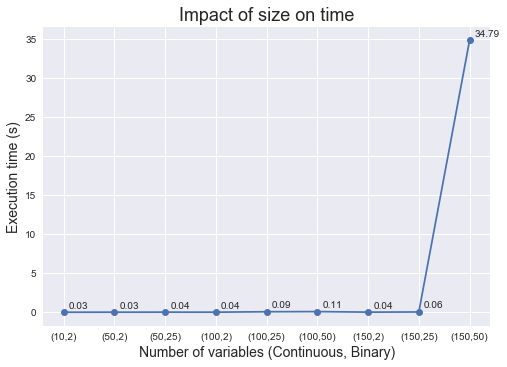

In [15]:
x_labels = []
for i in n:
    for j in m:
        if(j < i):
            x_labels.append("({},{})".format(i,j))
            
plt.figure()
plt.plot(x_labels, exec_times, '-o')
plt.xlabel("Number of variables (Continuous, Binary)", fontweight=250, fontsize=14)
plt.ylabel("Execution time (s)", fontweight=250, fontsize=14)
plt.title("Impact of size on time", fontweight=500, fontsize=18)
for i in range(0,9):
    plt.annotate(round(exec_times[i],2), xy=(i,exec_times[i]), xytext=(i+0.1,exec_times[i]+0.5))
plt.show()

The expected result of increasing the size of our model would be that time would increase proportionally to the number of variables.

Nevertheless, in our case we see that initially the time does not vary almost, being the same minimum. But from the last value onwards it grows in a very pronounced way. Cases with more variables than the latter have been tested, but the time it took to solve the problem was higher than the order of minutes, so these simulations have been discarded. Indeed, I have not been able to find a sensible justification for the fact of such an exponential growth so that the problem becomes unsolvable at practice "all of a sudden", with a relative minimal change in the size.
***

## Sensitivity analysis on parameters

For performing a sensitivity analysis on one of our parameters, we are going to choose the **production costs of Hydroelectric**.
This parameter is chosen because, as has been seen in the solution in the first section, this source is the one with the most production, due to the fact that it is clean (so it complies with the restriction on emissions) and also cheap (so it minimises the target cost function). Therefore, we decided to carry out the analysis on it. 

However, we will not perform the variation on a single parameter (i.e., we will not modify just the cost of "Hydroelectric - Andalucia" e.g.), but we will modify the average cost used to randomly generate the variable "c" of all the instances (i.e., we will modify all the parameters in the form "Hydroelectric - [...]").

In the definition of the Pyomo model (now <code>energy_opt_Sen</code>) we need to modify the loading of data, which now will be assign to a new .csv file not to overwrite the original one *production_data_Sen.csv* and then the returned object by the function, which will be now <code>instance.cost_obj()</code>


In [16]:
def energy_opt_Sen(D,E,K,idx):

    model = AbstractModel(name="Spanish energy production")
    
    data = DataPortal()
    
    ## SET
    model.P = Set()
    model.R = Set()
    
    ## PARAMETERS
    # Costs of electricity production
    model.c    = Param(model.P, within=NonNegativeReals)
    # Maximum capacities
    model.Cmax = Param(model.P, within=NonNegativeReals)
    # CO2 emissions factor
    model.a    = Param(model.P, within=NonNegativeReals)
    # Big-M values
    model.M    = Param(model.R, within=PositiveReals)
    
    data.load(filename="production_data_Sen.csv", using="csv", param=(model.c,model.Cmax,model.a), index=model.P)
    data.load(filename="region_data.csv", using="csv", param=model.M, index=model.R)
    
    ## DECISION VARIABLES
    # Electricity produced in each facility
    model.x = Var(model.P, within=NonNegativeReals)
    # Binary variables for k-folds alternative constraints
    model.y = Var(model.R, within=Binary)

    ## OBJECTIVE FUNCTION
    # Minimize the total cost of electricity production
    def cost_rule(model):
        return sum(model.c[i]*model.x[i] for i in model.P)
    model.cost_obj = Objective(rule=cost_rule)

    ## CONSTRAINTS
    # Meeting demand
    def demand_rule(model):
        return sum(model.x[i] for i in model.P) >= D
    model.demand_constraint = Constraint(rule=demand_rule)

    # CO2 emissions cap
    def emissions_rule(model):
        return sum(model.a[i]*model.x[i] for i in model.P) <= E
    model.emissions_constraint = Constraint(rule=emissions_rule)

    # Capacity limits
    def capacity_rule(model, i):
        return model.x[i] <= model.Cmax[i]
    model.capacity_constraint = Constraint(model.P, rule=capacity_rule)
    
    # Clean energy
    def clean_rule(model, j):          
        return sum(model.x[i] for i in idx.loc[j]) <= model.M[j]*(1-model.y[j])
    model.clean_constraint = Constraint(model.R, rule=clean_rule) 
    
    # K-folds alternatives
    def kfolds_rule(model):
        return sum(model.y[j] for j in model.R) >= K
    model.kfolds_constraint = Constraint(rule=kfolds_rule)
        
    instance = model.create_instance(data)
    opt.solve(instance)
 
    return instance.cost_obj()

In [17]:
n_instances = 20 #Number of different instance to evaluate (different values for parameter)
mean_costs_H = np.linspace(30, 200, n_instances)
opt_costs = []

for i in range(0, n_instances):
    df.loc[idx_H, "c"] = np.random.normal(loc=mean_costs_H[i], scale=5, size=len(idx_H))
    df.to_csv(path_or_buf="production_data_Sen.csv", index=False)
    opt_costs.append( energy_opt_Sen(D,E,K,idx) )

In [18]:
opt_costs

[3428628.5168990204,
 3589748.627086123,
 3768939.9746396095,
 3894088.1033753282,
 4043589.2022767705,
 4203577.117978852,
 4372294.981643916,
 4475903.558368203,
 4672376.148498488,
 4832437.107732637,
 4995782.120959143,
 5160871.335810187,
 5274310.383556119,
 5430264.225491952,
 5538347.850895046,
 5667717.31989712,
 5803831.071506821,
 5981354.649073078,
 6057311.689399102,
 6218707.096810633]

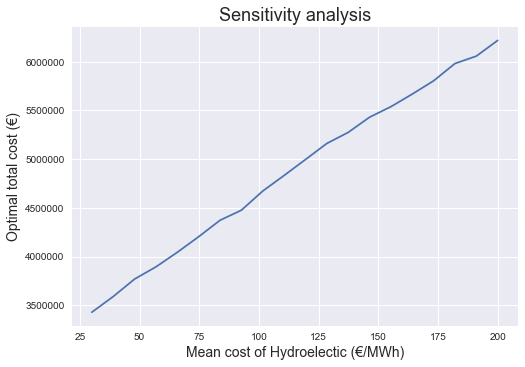

In [19]:
plt.figure()
plt.plot(mean_costs_H, opt_costs)
plt.xlabel("Mean cost of Hydroelectic (€/MWh)", fontweight=250, fontsize=14)
plt.ylabel("Optimal total cost (€)", fontweight=250, fontsize=14)
plt.title("Sensitivity analysis", fontweight=500, fontsize=18)
plt.show()

As we can see from the graph, the results are predictable, since *Hydroelectric* power was the form of electricity production most used in the optimal solution of our original model, since it is a cheap and clean source, so its use was "optimal". Thus, we observe an almost linear increase in the total cost of production (objective function, $z^*$) as a function of the mean cost of hydroelectric production, (which affects a number of $c_{H,j}$ parameter directly, since it is generated through a random number generator based on a normal distribution centered on that value). Therefore, the very slight oscillations are due to the variance of this distribution (defined by the standard deviation in the general time of the values).
***